In [2]:
import sys
sys.path.append('/net/hypernova/data2/BOOMPJE/code/ic_generation/')

import numpy as np
import read_tipsy
import os
from sphviewer.tools import QuickView
from scipy.spatial import distance
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib
plt.rcParams['figure.dpi'] = 360
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['text.usetex'] = True
rc("animation", html = "jshtml")

### Plot

In [ ]:
def plot(sim_path):
    fig, ax = plt.subplots(figsize=(7, 7))
    _, _, x, y, z, _, _, _, _= read_tipsy.read_file(f'/net/hypernova/data2/BOOMPJE/{sim_path}')
    pos = np.array([x,y,z]).T
    qv = QuickView(pos, r='infinity', plot=False)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(f'{sim_path}', y=1.03)
    ax.imshow(qv.get_image(), extent=qv.get_extent(), origin='lower', cmap='gist_heat')
    #plt.savefig(f'./img/{sim_path}.png')

#plot('merging_429_1073710/evolution_00021.4504-0')

### Get initial parameters

In [3]:
def read_parameters(path):
    log = {}
    with open(f'/net/hypernova/data2/BOOMPJE/{path}/parameters.log') as f:
        f = f.readlines()
        for line in f:
            key, value = line.strip().split(':')
            try:
                log[key.strip()] = float(value.strip())
            except:
                log[key.strip()] = value.strip()
    return log

### Plot density QV

In [ ]:
def load_data(directory):
    files = [f for f in os.listdir(directory) if f.startswith('evolution')]
    files.sort()
    num_files = len(files)
    pos, time, vel, par, ids = [], np.empty(num_files), [], [], []
    time = np.empty(num_files)
    
    for i, file in enumerate(files):
        full_path = os.path.join(directory, file)
        time[i] = float(file[10:-2])
        h, m, x, y, z, vx, vy, vz, id = read_tipsy.read_file(full_path)
        par.append([h, m, id])
        vel.append([vx, vy, vz])
        pos.append(np.column_stack((x, y, z)))
        ids.append(id)
    return pos, 15*time, vel, par, ids  # !t=15H0

path = 'merging_0_1072098'
pos, time, _, _, _ = load_data(f'/net/hypernova/data2/BOOMPJE/{path}')
param = read_parameters(path)

m_r = r'$M_{s}/M_{c}$ = ' + f'${round(param["mass_ratio"], 4)}$'
c_con = r'$c_{cen}$ = ' + f'${round(param["cen_concentration"], 4)}$'
s_con = r'$c_{sat}$ = ' + f'${round(param["sat_concentration"], 4)}$'
cen_slope = r'$\alpha_{cen}$ = ' + f'${round(param["cen_inner_slope"], 4)}$'
sat_slope = r'$\alpha_{sat}$ = ' + f'${round(param["sat_inner_slope"], 4)}$'
per_d = r'$r_{p}$ = ' + f'${round(param["pericentre_distance"], 4)}$'
e = r'$e$ = ' + f'${round(param["eccentricity"], 4)}$'

In [ ]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(7, 7))

def init():
    return ax,

def update(frame):
    positions = pos[frame]
    qv = QuickView(positions, extent=[-3, 3, -3, 3], r='infinity', plot=False)  # ! optimize
    ax.cla()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_aspect('equal')
    ax.set_title(f'Simulation {int(param["simulation_id"])}' + '\n' + fr'$\tau$ = {np.around(time[frame], decimals=4)} ' + r'$H_{0}^{-1}$', y=1.03)
    img = qv.get_image()
    ax.imshow(img, extent=qv.get_extent(), origin='lower', cmap='gist_heat')
    ax.text(2.6, 2.6, f'{m_r}\n{c_con}\n{s_con}\n{cen_slope}\n{sat_slope}\n{per_d}\n{e}', ha='right', va='top')
    return ax,

#ani = animation.FuncAnimation(fig, update, frames=len(pos), init_func=init, blit=False)
#ani.save(f'dens_simulation_{int(param["simulation_id"])}.mp4', fps=120)

### Classify particles in halos

In [4]:
def separate_ids(sim_path):
    _, m, _, _, _, _, _, _, ids = read_tipsy.read_file(f'/net/hypernova/data2/BOOMPJE/{sim_path[:19]}/stacked_objects')
    ids.sort()
    cen_ids = ids[:int(1e6)]
    return cen_ids

def separate_halos(cen_ids, sim_path):
    _, m, x, y, z, vx, vy, vz, ids = read_tipsy.read_file(f'/net/hypernova/data2/BOOMPJE/{sim_path}')
    mask = np.isin(ids, cen_ids)
    halos = {
        'cen': {
            'pos': np.column_stack((x[mask], y[mask], z[mask])),
            'vel': np.column_stack((vx[mask], vy[mask], vz[mask])),
            'm': m[mask]},
        'sat': {
            'pos': np.column_stack((x[~mask], y[~mask], z[~mask])),
            'vel': np.column_stack((vx[~mask], vy[~mask], vz[~mask])),
            'm': m[~mask]}}
    return halos

In [5]:
def load_data(directory):
    direc = f'/net/hypernova/data2/BOOMPJE/{directory}'
    files = [f for f in os.listdir(direc) if f.startswith('evolution')]
    files.sort()
    time = []
    for file in files:
        time.append(float(file[10:-2]))
    return 15*np.array(time), files #!t=15H0

In [6]:
#fig, ax = plt.subplots(figsize=(7, 7))

def init():
    return ax,

def update(frame):
    ax.cla()
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2, 2)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    halos = separate_halos(ids, f'{sim_path}/{files[frame]}')
    pos_c, pos_s = halos['cen']['pos'].T, halos['sat']['pos'].T
    ax.scatter(pos_c[0], pos_c[1], s=1e-13, c='navy')
    ax.scatter(pos_s[0], pos_s[1], s=1e-13, c='red')
    return ax,

#ani = animation.FuncAnimation(fig, update, frames=len(files), init_func=init, blit=False)
#ani.save(f'halos_simulation_{int(params['simulation_id'])}.mp4', fps=120)

### $\rho$

In [7]:
def find_center(positions, masses, radius=0.1, max_iter=100, tol=1e-4):
    center = np.mean(positions, axis=0)
    for _ in range(max_iter):
        distances = np.linalg.norm(positions - center, axis=1)
        mask = distances < radius
        new_center = np.sum(positions[mask].T * masses[mask], axis=1) / np.sum(masses[mask])
        if np.linalg.norm(new_center - center) < tol:
            break
        center = new_center
    return center

def calculate_distances(positions, center):
    distances = np.linalg.norm(positions - center, axis=1)
    return distances

def calculate_mass_density(distances, masses, num_bins=150):
    hist, bin_edges = np.histogram(distances, bins=num_bins, weights=masses)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_volumes = 4/3 * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
    density = hist / bin_volumes
    return bin_centers, density

/var/tmp/vtorresgomez/ipykernel_2076121/1244184015.py:37: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  orbit_c.set_data(dense_center_cen[0], dense_center_cen[1])
/var/tmp/vtorresgomez/ipykernel_2076121/1244184015.py:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  orbit_s.set_data(dense_center_sat[0], dense_center_sat[1])


KeyboardInterrupt: 

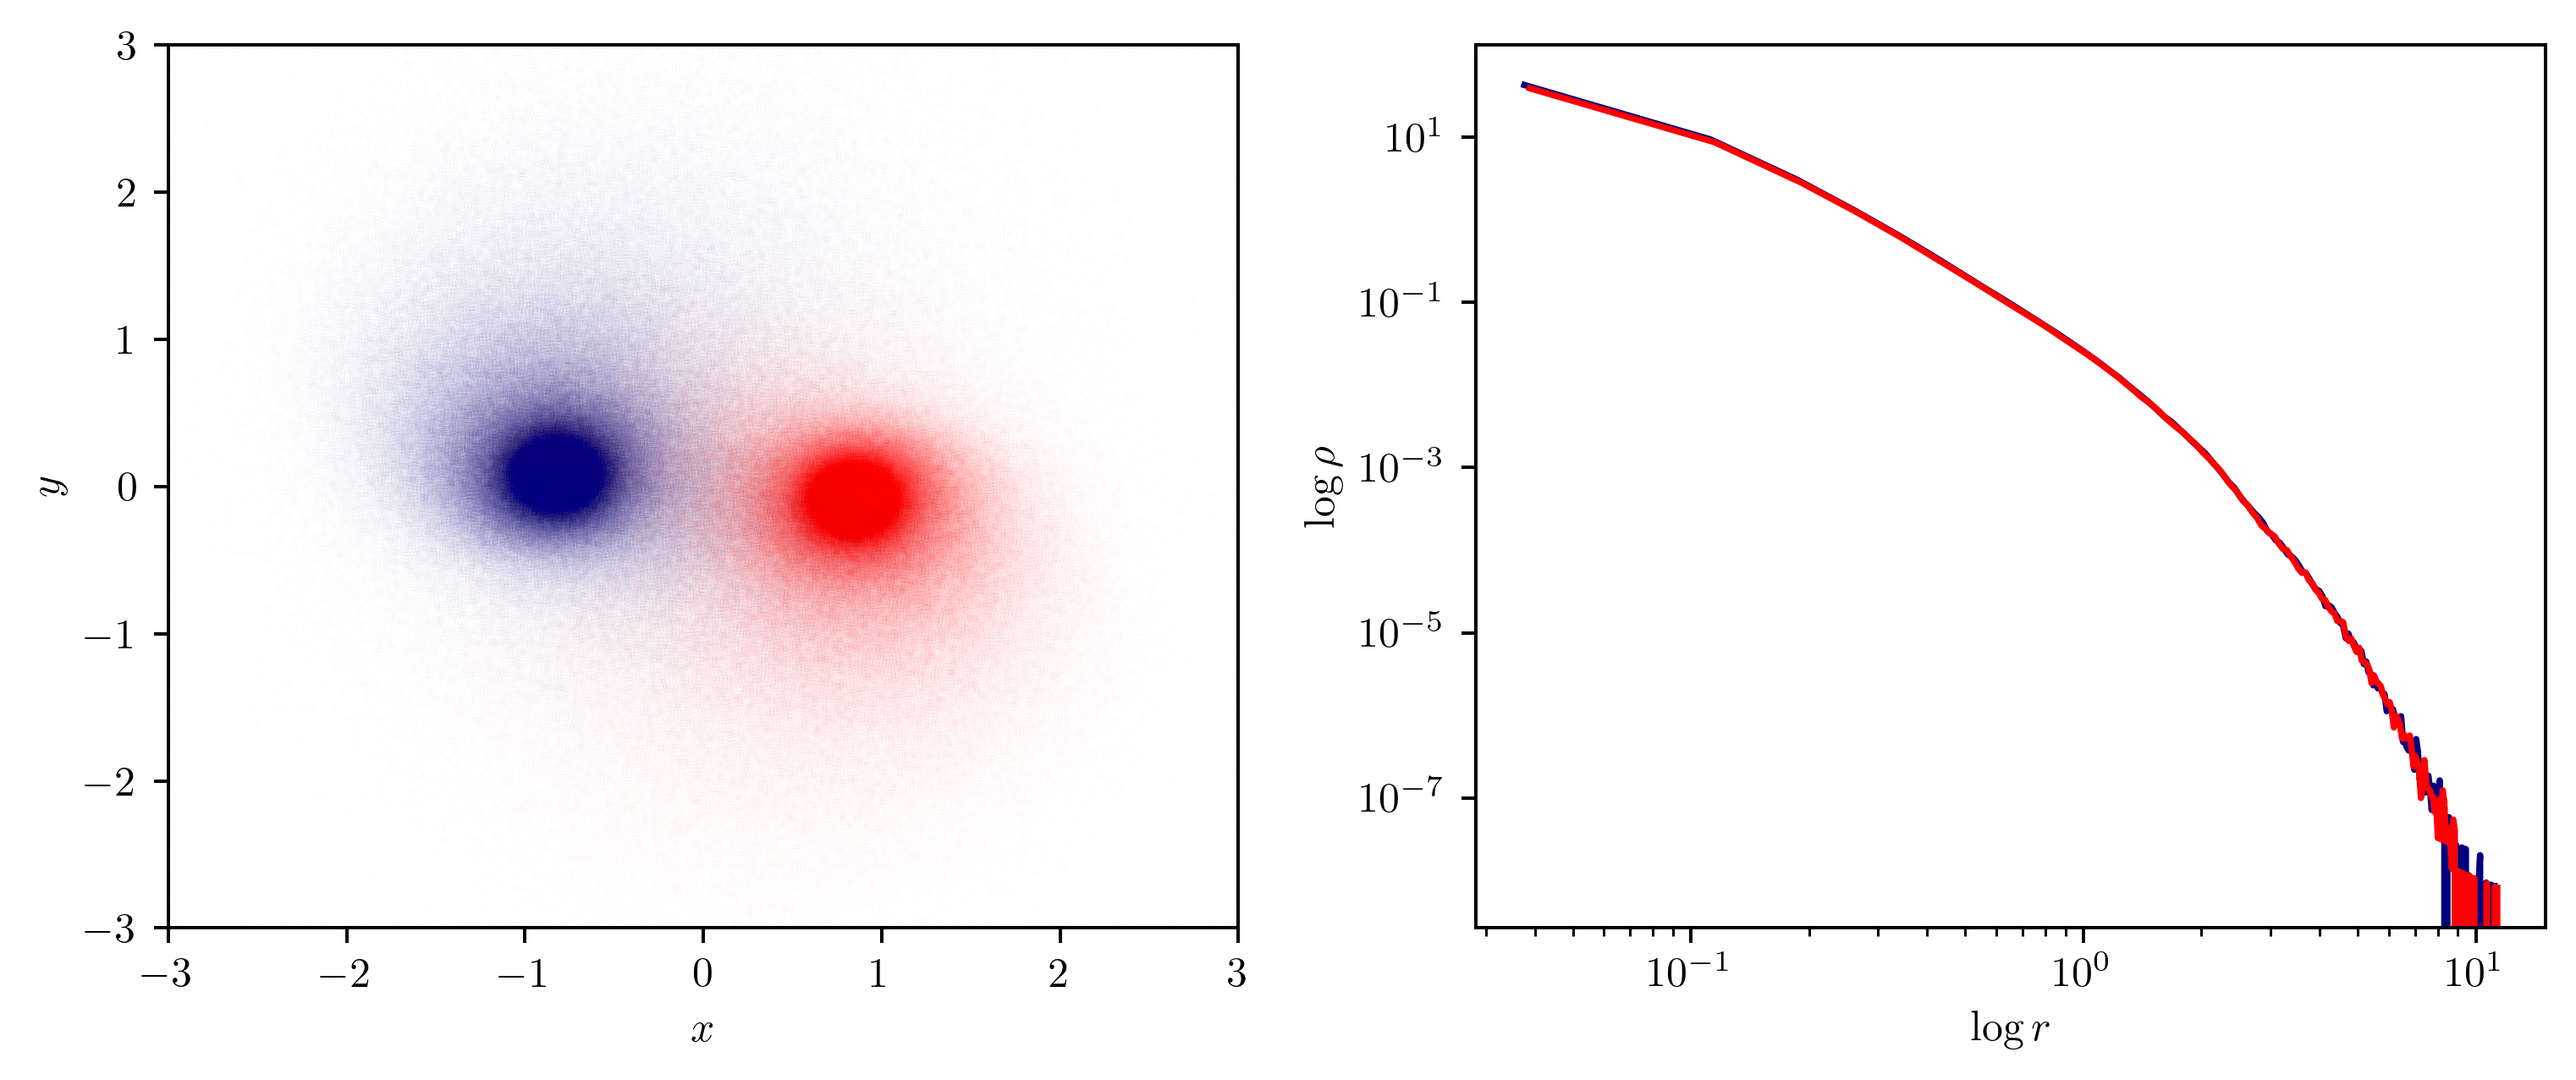

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
fig.tight_layout(pad=3)

sim_path = 'merging_429_1073710'
param = read_parameters(sim_path)
cen_ids = separate_ids(sim_path)
time, files = load_data(sim_path)

orbit_c, = ax1.plot([], [], '--', lw=1, c='navy')
orbit_s, = ax1.plot([], [], '--', lw=1, c='red')

def init(): 
    orbit_c.set_data([], [])
    orbit_s.set_data([], [])
    return ax1, ax2, orbit_c, orbit_s

def update(frame):
    ax1.cla()
    ax2.cla()
    
    #*scatter for particles, ax1
    halos = separate_halos(cen_ids, f'{sim_path}/{files[frame]}')
    dense_center_cen = find_center(halos['cen']['pos'], halos['cen']['m'])
    dense_center_sat = find_center(halos['sat']['pos'], halos['sat']['m'])
    distances_cen = calculate_distances(halos['cen']['pos'], dense_center_cen)
    distances_sat = calculate_distances(halos['sat']['pos'], dense_center_sat)
    bin_centers_cen, density_cen = calculate_mass_density(distances_cen, halos['cen']['m'])
    bin_centers_sat, density_sat = calculate_mass_density(distances_sat, halos['sat']['m'])
    ax2.plot(bin_centers_cen, density_cen, label='Central', c='navy')
    ax2.plot(bin_centers_sat, density_sat, label='Satellite', c='red')
    ax2.set_xlabel(r'$\log{r}$')
    ax2.set_ylabel(r'$\log{\rho}$')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    
    #*line for orbits, ax1
    orbit_c.set_data(dense_center_cen[0], dense_center_cen[1])
    orbit_s.set_data(dense_center_sat[0], dense_center_sat[1])
    
    #*scatter for ax2, density
    pos_c, pos_s = halos['cen']['pos'].T, halos['sat']['pos'].T
    ax1.scatter(pos_c[0], pos_c[1], s=1e-13, c='navy')
    ax1.scatter(pos_s[0], pos_s[1], s=1e-13, c='red')
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$y$')
    ax1.set_xlim(-3,3)
    ax1.set_ylim(-3,3)
    
    #plt.suptitle(f'Simulation {int(param["simulation_id"])}', y=1.03)
    return (ax1, ax2, orbit_c, orbit_s),

ani = animation.FuncAnimation(fig, update, frames=len(files)-1, init_func=init, blit=False)
ani.save(f'rho_simulation_{int(param['simulation_id'])}.mp4', fps=10)

KeyboardInterrupt: 

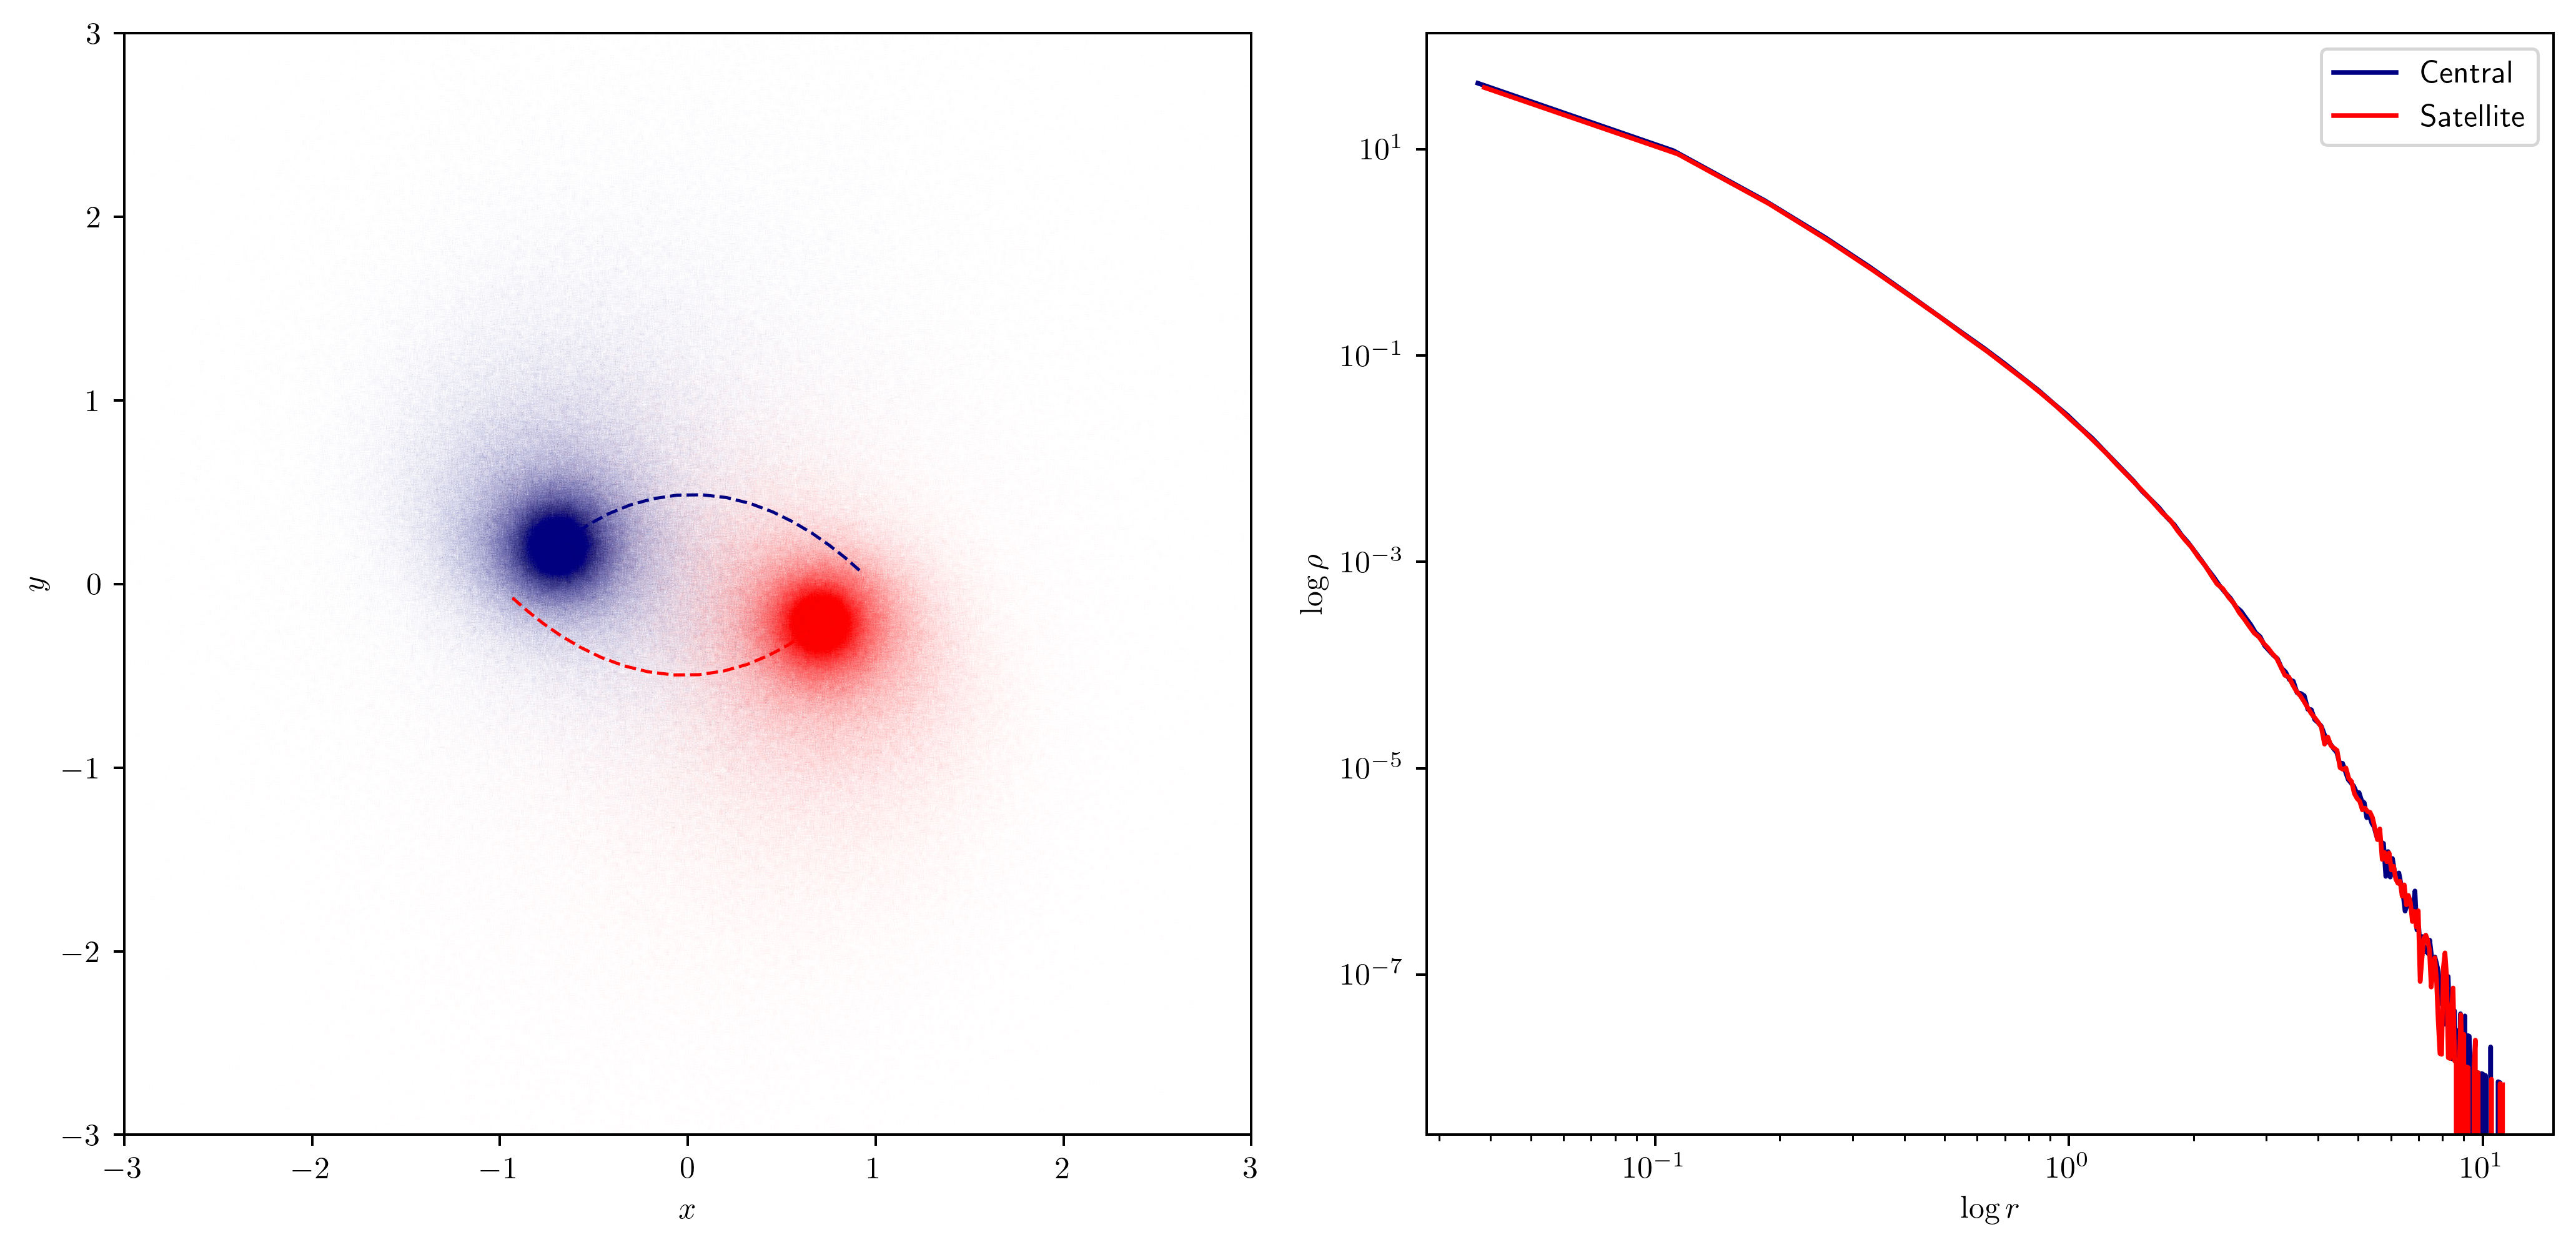

In [18]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.tight_layout(pad=3)

sim_path = 'merging_429_1073710'
param = read_parameters(sim_path)
cen_ids = separate_ids(sim_path)
time, files = load_data(sim_path)

orbit_cen_x, orbit_cen_y = [], []
orbit_sat_x, orbit_sat_y = [], []

def init():
    orbit_c.set_data([], [])
    orbit_s.set_data([], [])
    return ax1, ax2, orbit_c, orbit_s

def update(frame):
    ax1.cla()
    ax2.cla()
    
    #* scatter for particles, ax1
    halos = separate_halos(cen_ids, f'{sim_path}/{files[frame]}')
    dense_center_cen = find_center(halos['cen']['pos'], halos['cen']['m'])
    dense_center_sat = find_center(halos['sat']['pos'], halos['sat']['m'])
    
    #* orbits in ax2
    orbit_cen_x.append(dense_center_cen[0])
    orbit_cen_y.append(dense_center_cen[1])
    orbit_sat_x.append(dense_center_sat[0])
    orbit_sat_y.append(dense_center_sat[1])
    orbit_c.set_data(orbit_cen_x, orbit_cen_y)
    orbit_s.set_data(orbit_sat_x, orbit_sat_y)
    ax1.plot(orbit_cen_x, orbit_cen_y, '--', lw=1, c='navy')
    ax1.plot(orbit_sat_x, orbit_sat_y, '--', lw=1, c='red')
    
    #* particles in ax1
    pos_c, pos_s = halos['cen']['pos'].T, halos['sat']['pos'].T
    ax1.scatter(pos_c[0], pos_c[1], s=1e-13, c='navy')
    ax1.scatter(pos_s[0], pos_s[1], s=1e-13, c='red')
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$y$')
    ax1.set_xlim(-3, 3)
    ax1.set_ylim(-3, 3)
    
    #* scatter for rho in ax2
    distances_cen = calculate_distances(halos['cen']['pos'], dense_center_cen)
    distances_sat = calculate_distances(halos['sat']['pos'], dense_center_sat)
    bin_centers_cen, density_cen = calculate_mass_density(distances_cen, halos['cen']['m'])
    bin_centers_sat, density_sat = calculate_mass_density(distances_sat, halos['sat']['m'])
    ax2.plot(bin_centers_cen, density_cen, label='Central', c='navy')
    ax2.plot(bin_centers_sat, density_sat, label='Satellite', c='red')
    ax2.set_xlabel(r'$\log{r}$')
    ax2.set_ylabel(r'$\log{\rho}$')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.legend()
    
    return ax1, ax2, orbit_c, orbit_s

ani = animation.FuncAnimation(fig, update, frames=len(files)-1, init_func=init, blit=False)
ani.save(f'rho_simulation_{int(param["simulation_id"])}.mp4', fps=10)

### $r(t)$

In [ ]:
sim_path = 'merging_0_1072098'
param = read_parameters(sim_path)
ids = separate_ids(sim_path)
time, files = load_data(sim_path)
dist, cm = [], []

for f in files:
    try:    #!last files are weird
        halos = separate_halos(ids, f'{sim_path}/{f}')
        cm_cen = np.sum(halos['cen']['m']*halos['cen']['pos'].T, axis=1)/np.sum(halos['cen']['m'])
        cm_sat = np.sum(halos['sat']['m']*halos['sat']['pos'].T, axis=1)/np.sum(halos['sat']['m'])
        cm.append([cm_cen, cm_sat])
        dist.append(np.linalg.norm(cm_cen-cm_sat))
    except:
        pass

In [ ]:
m_r = r'$M_{s}/M_{c}$ = ' + f'${round(param['mass_ratio'], 4)}$'
c_con = r'$c_{cen}$ = ' + f'${round(param['cen_concentration'], 4)}$'
s_con = r'$c_{sat}$ = ' + f'${round(param['sat_concentration'], 4)}$'
cen_slope = r'$\alpha_{cen}$ = ' + f'${round(param['cen_inner_slope'], 4)}$'
sat_slope = r'$\alpha_{sat}$ = ' + f'${round(param['sat_inner_slope'], 4)}$'
per_d = r'$r_{p}$ = ' + f'${round(param['pericentre_distance'], 4)}$'
e = r'$e$ = ' + f'${round(param['eccentricity'], 4)}$'

fig, ax = plt.subplots(figsize=(7, 7))
rp, ra = min(dist), max(dist)

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$r$')
ax.set_title(f'Simulation {int(param["simulation_id"])}', y=1.03)
ax.plot(time, dist, c='black', marker='.')
ax.axhline(y=ra, c='blue', label=r'$r_{a}$', ls='--')
ax.axhline(y=rp, c='red', label=r'$r_{p}$', ls='--')
#ax.text(max(time)*0.95, max(dist)*0.98, f'{m_r}\n{c_con}\n{s_con}\n{cen_slope}\n{sat_slope}\n{per_d}\n{e}', ha='right', va='top')
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
cm1, d1 = np.array(cm), np.array(dist)
rp, ra = params['pericentre_distance'], ((1+param['eccentricity'])*rp)/(1-param['eccentricity'])

def init(): 
    return ax,

def update(frame):
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$r$')
    ax.scatter(time[frame], dist[frame], s=2, c='navy')
    ax.axhline(y=ra, c='blue', label=r'$r_{a}$')
    ax.axhline(y=rp, c='red', label=r'$r_{p}$')
    ax.set_title(f'Simulation {int(params["simulation_id"])}', y=1.03)
    return ax,

#ani = animation.FuncAnimation(fig, update, frames=len(files)-1, init_func=init, blit=False)
#ani.save(f'orbits1_simulation_{int(params['simulation_id'])}.mp4', fps=120)